In [2]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [3]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer, T5Tokenizer, TFT5ForConditionalGeneration, PegasusTokenizer, TFPegasusForConditionalGeneration

# Data

In [4]:
train_section = pd.read_table("train_dataset.csv", sep='\t', index_col=0)
val_section = pd.read_table("val_dataset.csv", sep='\t', index_col=0)
test_section = pd.read_table("test_dataset.csv", sep='\t', index_col=0)

In [5]:
test_section.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,isbiased,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel,TFIDF
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,1,1,a minister who compared gays to pedophiles and...,Biased,0,0,0,0,0,0
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,0,nra ad: are the president's kids more importan...,Neutral,0,0,0,0,1,0
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,1,-1,back to previous page obama hits a wall in ber...,Biased,0,0,0,0,0,0
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,1,1,"montpelier, idaho (ap) — republicans have made...",Biased,0,0,0,1,0,0
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,1,1,washington — finally unburdened by worries abo...,Biased,0,0,0,1,0,0


In [255]:
test_article_text = list(test_section["text"])


## Model

In [253]:
t5_model = TFT5ForConditionalGeneration.from_pretrained('t5-large')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-large')

t5_model.summary()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "tf_t5for_conditional_generation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared (TFSharedEmbeddings)  multiple                  32899072  
_________________________________________________________________
encoder (TFT5MainLayer)      multiple                  302040576 
_________________________________________________________________
decoder (TFT5MainLayer)      multiple                  402728448 
Total params: 737,668,096
Trainable params: 737,668,096
Non-trainable params: 0
_________________________________________________________________


In [256]:
t5_test_article_text = ["summarize: " + i for i in test_article_text]

In [257]:
t5_input_list = [ t5_tokenizer([i],  max_length=512,  truncation=True, return_tensors='tf') for i in t5_test_article_text]

In [258]:
t5_summary_ids =  [t5_model.generate(i['input_ids'],
                                    num_beams=3,
                                    no_repeat_ngram_size=1,
                                    min_length=35,
                                    max_length=80) for i in t5_input_list]


In [259]:
t5_summary_list = [[t5_tokenizer.decode(g, skip_special_tokens=True, 
                           clean_up_tokenization_spaces=False) for g in i] for i in t5_summary_ids]

In [260]:
t5_summaries = [i[0] for i in t5_summary_list]

In [16]:
# test_section.to_csv("test_dataset.csv", sep='\t')

In [263]:
tf.keras.backend.clear_session()

In [264]:
pegasus_model = TFPegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
pegasus_tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')

pegasus_model.summary()

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

All the layers of TFPegasusForConditionalGeneration were initialized from the model checkpoint at google/pegasus-xsum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.


Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (TFPegasusMainLayer)   multiple                  569748480 
Total params: 569,844,583
Trainable params: 569,748,480
Non-trainable params: 96,103
_________________________________________________________________


In [265]:
pegasus_input_list = [pegasus_tokenizer([i], max_length=512, truncation=True, return_tensors='tf') for i in test_article_text]

In [266]:
pegasus_summary_ids =  [pegasus_model.generate(i['input_ids'], 
                                    no_repeat_ngram_size=2,
                                    min_length=35,
                                    max_length=80,
                                    early_stopping=True) for i in pegasus_input_list]

In [267]:
pegasus_summary_list = [[pegasus_tokenizer.decode(g, skip_special_tokens=True, 
                           clean_up_tokenization_spaces=False) for g in i] for i in pegasus_summary_ids]

In [268]:
pegasus_summaries = [i[0] for i in pegasus_summary_list]
test_section["pegasus_summaries"] = pegasus_summaries

In [271]:
# data["pegasus_summaries"] = pegasus_summaries

In [14]:
test_section.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel,t5_summaries,pegasus_summaries
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,1,a minister who compared gays to pedophiles and...,Biased,0,0,0,0,0,gop's ken cuccinelli has been downplaying his ...,The Republican Party in Virginia is trying to ...
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,nra ad: are the president's kids more importan...,Neutral,0,0,0,0,1,president obama unveiled legislative proposals...,In the wake of last week's school shooting in ...
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,-1,back to previous page obama hits a wall in ber...,Biased,0,0,0,0,0,"david frum: obama's second term will be silly,...","The president of the United States of America,..."
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,1,"montpelier, idaho (ap) — republicans have made...",Biased,0,0,0,1,0,republicans have made the mountain west a stro...,"In the mountains of western virginia, republic..."
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,1,washington — finally unburdened by worries abo...,Biased,0,0,0,1,0,president obama is noticeably quicker to speak...,With less than two weeks to go before American...


In [19]:
test_section.to_csv("test_dataset.csv", sep='\t')

## Evaluating summary bias using XLNet

In [4]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['label']))
val_labels = np.asarray(le.transform(val_section['label']))

In [6]:
tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [7]:
MAX_LEN = 512

In [9]:

def create_input_array(df, tokenizer, text):
    sentences = df[text].values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LEN,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)


    return input_ids, attention_masks, token_type_ids
#     return input_ids, attention_masks



In [10]:
def convert_inputs_to_tf_dataset(inputs):
    # args.max_seq_len = 256
    ids = inputs[0][0]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, MAX_LEN))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, MAX_LEN))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, MAX_LEN))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()
#     return[ids]
#     return [ids, masks, token_types]
    return [ids, masks]

In [13]:
model = TFXLNetForSequenceClassification.from_pretrained("data/experiments/BinaryXLNetmodels", num_labels=len(np.unique(train_labels)))
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFXLNetForSequenceClassification.

All the layers of TFXLNetForSequenceClassification were initialized from the model checkpoint at data/experiments/BinaryXLNetmodels.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetForSequenceClassification for predictions without further training.


In [14]:
model.summary()

Model: "tfxl_net_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFXLNetMainLaye multiple                  360268800 
_________________________________________________________________
sequence_summary (TFSequence multiple                  1049600   
_________________________________________________________________
logits_proj (Dense)          multiple                  2050      
Total params: 361,320,450
Trainable params: 361,320,450
Non-trainable params: 0
_________________________________________________________________


## Predicting T5 Summary Labels

In [66]:
test_section["t5_summaries"].head()

0    gop's ken cuccinelli has been downplaying his ...
1    president obama unveiled legislative proposals...
2    david frum: obama's second term will be silly,...
3    republicans have made the mountain west a stro...
4    president obama is noticeably quicker to speak...
Name: t5_summaries, dtype: object

In [55]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer, text = "t5_summaries")]
test_data = convert_inputs_to_tf_dataset(test_inputs)

Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [56]:
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [57]:
test_probs = test_probs["logits"]

In [58]:
test_classes = np.argmax(test_probs, axis = 1)

In [59]:
# t5 summaries
test_classes

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1])

In [60]:
test_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [61]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

Test accuracy:
0.6818181818181818


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [63]:
# accuracy: (tp + tn) / (p + n)
t5accuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % t5accuracy)
# precision tp / (tp + fp)
t5precision = precision_score(test_labels, test_classes)
print('Precision: %f' % t5precision)
# recall: tp / (tp + fn)
t5recall = recall_score(test_labels, test_classes)
print('Recall: %f' % t5recall)
# f1: 2 tp / (2 tp + fp + fn)
t5f1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % t5f1)
 

Accuracy: 0.681818
Precision: 0.675325
Recall: 0.838710
F1 score: 0.748201


In [64]:
t5metrics = [t5accuracy, t5precision, t5recall, t5f1]

## Predicting Pegasus Summary Labels

In [65]:
test_section["pegasus_summaries"].head()

0    The Republican Party in Virginia is trying to ...
1    In the wake of last week's school shooting in ...
2    The president of the United States of America,...
3    In the mountains of western virginia, republic...
4    With less than two weeks to go before American...
Name: pegasus_summaries, dtype: object

In [67]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer, text = "pegasus_summaries")]
test_data = convert_inputs_to_tf_dataset(test_inputs)

Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [68]:
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [69]:
test_probs = test_probs["logits"]

In [70]:
test_classes = np.argmax(test_probs, axis = 1)

In [71]:
test_classes

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [73]:
test_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [74]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

Test accuracy:
0.7272727272727273


In [75]:
# accuracy: (tp + tn) / (p + n)
pegasusaccuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % pegasusaccuracy)
# precision tp / (tp + fp)
pegasusprecision = precision_score(test_labels, test_classes)
print('Precision: %f' % pegasusprecision)
# recall: tp / (tp + fn)
pegasusrecall = recall_score(test_labels, test_classes)
print('Recall: %f' % pegasusrecall)
# f1: 2 tp / (2 tp + fp + fn)
pegasusf1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % pegasusf1)
 

Accuracy: 0.727273
Precision: 0.677778
Recall: 0.983871
F1 score: 0.802632


In [76]:
pegasusmetrics = [pegasusaccuracy, pegasusprecision, pegasusrecall, pegasusf1]

## Double checking our loaded model is the correct model

In [34]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer, text = "text")]
test_data = convert_inputs_to_tf_dataset(test_inputs)

test_probs = model.predict(test_data, batch_size= 1, verbose=0)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


In [35]:
test_probs = test_probs["logits"]

In [36]:
test_classes = np.argmax(test_probs, axis = 1)

In [37]:
test_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0])

In [45]:
test_classes == list(test_section["XLNet"])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

## TF-IDF Label Prediction

In [77]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [78]:
# tf-idf processing from https://github.com/williamscott701/Information-Retrieval/blob/master/2.%20TF-IDF%20Ranking%20-%20Cosine%20Similarity%2C%20Matching%20Score/TF-IDF.ipynb

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text


def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")


def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text


def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text


def preprocess(data):
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [79]:
train_dataset = list(train_section["text"])
val_dataset = list(val_section["text"])
test_dataset = list(test_section["text"])


In [80]:
def process(dataset):
    processed_text = []
    for i in dataset:
#         processed_text.append(word_tokenize(str(preprocess(i))))
        processed_text.append(str(preprocess(i)))
    return processed_text


In [81]:
train_dataset = process(train_dataset)
val_dataset = process(val_dataset)
test_dataset = process(test_dataset)

In [82]:
# tf-idf from https://stackabuse.com/text-classification-with-python-and-scikit-learn/
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
trainX = vectorizer.fit_transform(train_dataset).toarray()
valX = vectorizer.transform(val_dataset).toarray()
testX = vectorizer.transform(test_dataset).toarray()

In [83]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
trainX = tfidfconverter.fit_transform(trainX).toarray()
valX = tfidfconverter.transform(valX).toarray()
testX = tfidfconverter.transform(testX).toarray()

In [ ]:

# train_labels = np.asarray(le.transform(train_section['label']))
# val_labels = np.asarray(le.transform(val_section['label']))
# test_labels = np.asarray(le.transform(test_section['label']))

In [84]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(trainX, train_labels) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [85]:
y_pred = classifier.predict(testX)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0])

#### TF-IDF T5 Summary Label Prediction

In [87]:
test_section["t5_summaries"].head()

0    gop's ken cuccinelli has been downplaying his ...
1    president obama unveiled legislative proposals...
2    david frum: obama's second term will be silly,...
3    republicans have made the mountain west a stro...
4    president obama is noticeably quicker to speak...
Name: t5_summaries, dtype: object

In [92]:
t5_summary_dataset = process(list(test_section["t5_summaries"]))
t5_summary_dataset = vectorizer.transform(t5_summary_dataset).toarray()
t5_summary_dataset = tfidfconverter.transform(t5_summary_dataset).toarray()

In [93]:
t5_pred = classifier.predict(t5_summary_dataset)
t5_pred

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1])

#### TF-IDF Pegasus Summary Label Prediction

In [98]:
test_section["pegasus_summaries"].head()

0    The Republican Party in Virginia is trying to ...
1    In the wake of last week's school shooting in ...
2    The president of the United States of America,...
3    In the mountains of western virginia, republic...
4    With less than two weeks to go before American...
Name: pegasus_summaries, dtype: object

In [99]:
pegasus_summary_dataset = process(list(test_section["pegasus_summaries"]))
pegasus_summary_dataset = vectorizer.transform(pegasus_summary_dataset).toarray()
pegasus_summary_dataset = tfidfconverter.transform(pegasus_summary_dataset).toarray()

In [100]:
pegasus_pred = classifier.predict(pegasus_summary_dataset)
pegasus_pred

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Data Analysis

In [203]:
t5_xlnet_predicted_labels = [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]

In [204]:
pegasus_xlnet_predicted_labels = [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [205]:
text_xlnet_predicted_labels = test_section["XLNet"]

In [206]:
t5_tfidf_predicted_labels = [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]

In [207]:
pegasus_tfidf_predicted_labels = [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [208]:
text_tfidf_predicted_labels = test_section["TFIDF"]

In [209]:
test_labels = [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]

In [210]:
predlist = [t5_xlnet_predicted_labels, 
            pegasus_xlnet_predicted_labels, 
            text_xlnet_predicted_labels, 
            t5_tfidf_predicted_labels, 
            pegasus_tfidf_predicted_labels,
            text_tfidf_predicted_labels]

In [211]:
namelist = ["XLNet (T5)",
           "XLNet (Pegasus)",
           "XLNet (Full Article)",
           "TF-IDF (T5)",
           "TF-IDF (Pegasus)",
           "TF-IDF (Full Article)"]

In [212]:
for i in range(len(predlist)):
    predlist[i] = 1-np.array(predlist[i])
test_labels =1-np.array(test_labels)

In [213]:
t5_xlnet_predicted_labels = predlist[0]
pegasus_xlnet_predicted_labels = predlist[1]
text_xlnet_predicted_labels = predlist[2]
t5_tfidf_predicted_labels = predlist[3]
pegasus_tfidf_predicted_labels = predlist[4]
text_tfidf_predicted_labels = predlist[5]

In [276]:
test_section["pegasus_summaries"] = pegasus_summaries
test_section["t5_summaries"] = t5_summaries

In [214]:
test_section['t5_xlnet_predicted_labels'] = t5_xlnet_predicted_labels
test_section['pegasus_xlnet_predicted_labels'] = pegasus_xlnet_predicted_labels
test_section['t5_tfidf_predicted_labels'] = t5_tfidf_predicted_labels
test_section['pegasus_tfidf_predicted_labels'] = pegasus_tfidf_predicted_labels
test_section['test_labels'] = test_labels
test_section.to_csv("test_dataset_final.csv", sep='\t')

In [ ]:
data["pegasus_summaries"] = pegasus_summaries

In [6]:
data = pd.read_table("test_dataset_final.csv", sep='\t', index_col=0)
data.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,ALBERT,encodedlabel,TFIDF,t5_xlnet_predicted_labels,pegasus_xlnet_predicted_labels,t5_tfidf_predicted_labels,pegasus_tfidf_predicted_labels,test_labels,t5_summaries,pegasus_summaries
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,0,0,0,1,1,1,0,1,gop's ken cuccinelli has been downplaying his ...,The Republican Party in Virginia is trying to ...
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,1,0,1,0,0,0,0,president obama unveiled legislative proposals...,In the wake of last week's school shooting in ...
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,0,0,0,1,0,1,0,1,"david frum: obama's second term will be silly,...","The president of the United States of America,..."
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,1,0,0,1,1,1,1,1,republicans have made the mountain west a stro...,"In the mountains of western virginia, republic..."
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,1,0,0,1,1,0,1,1,president obama is noticeably quicker to speak...,With less than two weeks to go before American...


In [216]:
modelaccuracylist = []
modelnamelist = []
modelprecisionlist = []
modelrecalllist = []
modelf1list = []
mlist = []
print("Metrics for Biased as baseline class (0):")
print()
for i in range(len(predlist)):
    test_classes = predlist[i]
    modelname = namelist[i]
    modelnamelist.append(modelname)
    print(modelname +" Metrics:")
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(test_labels, test_classes)
    print('Accuracy: %f' % accuracy)
    modelaccuracylist.append(accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(test_labels, test_classes)
    print('Precision: %f' % precision)
    modelprecisionlist.append(precision)
    # recall: tp / (tp + fn)
    recall = recall_score(test_labels, test_classes)
    print('Recall: %f' % recall)
    modelrecalllist.append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_labels, test_classes)
    modelf1list.append(f1)
    print('F1 score: %f' % f1)
    mlist.append([accuracy, precision, recall, f1])
#     print(classification_report(test_labels,test_classes))
    print("")
 

Metrics for Biased as baseline class (0):

XLNet (T5) Metrics:
Accuracy: 0.681818
Precision: 0.696970
Recall: 0.479167
F1 score: 0.567901

XLNet (Pegasus) Metrics:
Accuracy: 0.727273
Precision: 0.950000
Recall: 0.395833
F1 score: 0.558824

XLNet (Full Article) Metrics:
Accuracy: 0.809091
Precision: 0.813953
Recall: 0.729167
F1 score: 0.769231

TF-IDF (T5) Metrics:
Accuracy: 0.672727
Precision: 0.833333
Recall: 0.312500
F1 score: 0.454545

TF-IDF (Pegasus) Metrics:
Accuracy: 0.618182
Precision: 0.875000
Recall: 0.145833
F1 score: 0.250000

TF-IDF (Full Article) Metrics:
Accuracy: 0.772727
Precision: 0.709091
Recall: 0.812500
F1 score: 0.757282



In [287]:
df = pd.DataFrame(columns = modelnamelist)
df.loc['Accuracy'] = modelaccuracylist
df.loc['Precision'] = modelprecisionlist
df.loc['Recall'] = modelrecalllist
df.loc['F1'] = modelf1list
df.head()

,XLNet (T5),XLNet (Pegasus),XLNet (Full Article),TF-IDF (T5),TF-IDF (Pegasus),TF-IDF (Full Article)
Accuracy,0.681818,0.727273,0.809091,0.672727,0.618182,0.772727
Precision,0.696970,0.950000,0.813953,0.833333,0.875000,0.709091
Recall,0.479167,0.395833,0.729167,0.312500,0.145833,0.812500
F1,0.567901,0.558824,0.769231,0.454545,0.250000,0.757282


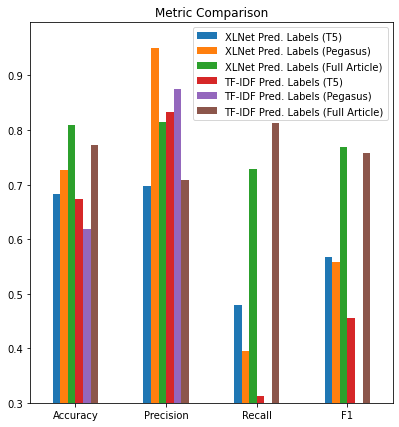

In [180]:
ax = df.plot.bar(rot=0)
ax.set_ylim(ymin=0.3)
ax.figure.set_size_inches(6.5, 7)
plt.title('Metric Comparison')
# plt.show()
plt.savefig('predlabelmodelmetriccomparison.jpg')

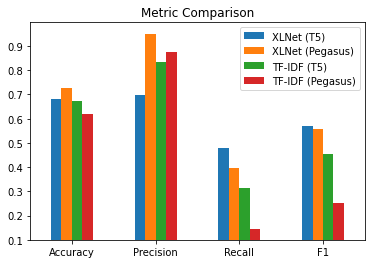

In [340]:

ax = df[["XLNet (T5)",
           "XLNet (Pegasus)",
           "TF-IDF (T5)",
           "TF-IDF (Pegasus)"]].plot.bar(rot=0)
ax.set_ylim(ymin=0.1)
ax.figure.set_size_inches(6, 4)
plt.title('Metric Comparison')
# plt.show()
plt.savefig('predlabelevalmodelmetriccomparison.jpg')

Text(0.5, 1.0, 'Metric Comparison')

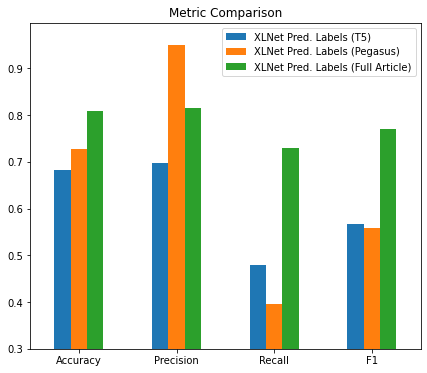

In [223]:
ax = df[["XLNet Pred. Labels (T5)", "XLNet Pred. Labels (Pegasus)", "XLNet Pred. Labels (Full Article)"]].plot.bar(rot=0)
ax.set_ylim(ymin=0.3)
ax.figure.set_size_inches(7, 6)
plt.title('Metric Comparison')

Text(0.5, 1.0, 'Metric Comparison')

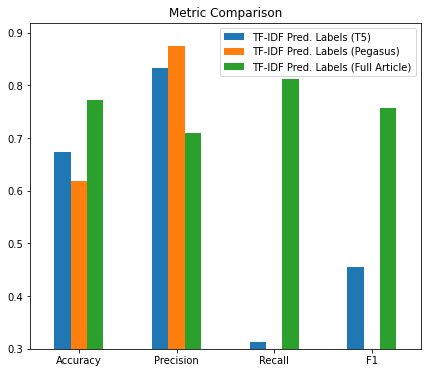

In [222]:
ax = df[["TF-IDF Pred. Labels (T5)", "TF-IDF Pred. Labels (Pegasus)", "TF-IDF Pred. Labels (Full Article)"]].plot.bar(rot=0)
ax.set_ylim(ymin=0.3)
ax.figure.set_size_inches(7, 6)
plt.title('Metric Comparison')

In [224]:
def calculateproportions(df, colname):
    biases = df[df[colname] == 1]
    neutrals = df[df[colname] == 0]
    length = df.shape[0]
    return biases.shape[0]/length, neutrals.shape[0]/length

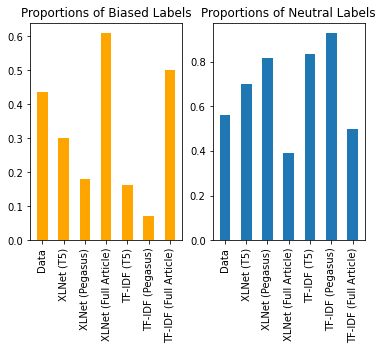

In [337]:

realbiasproportions, realneutralproportions = calculateproportions(data, "test_labels")
xlnett5biasproportions, xlnett5neutralproportions = calculateproportions(data, "t5_xlnet_predicted_labels")
xlnetpbiasproportions, xlnetpneutralproportions = calculateproportions(data, "pegasus_xlnet_predicted_labels")
xlnetbiasproportions, xlnetneutralproportions = calculateproportions(data, "XLNet")
tft5biasproportions, tft5neutralproportions = calculateproportions(data, "t5_tfidf_predicted_labels")
tfpbiasproportions, tfpneutralproportions = calculateproportions(data, "pegasus_tfidf_predicted_labels")
tfbiasproportions, tfneutralproportions = calculateproportions(data, "TFIDF")

# namelist = ["XLNet Pred. Labels (T5)",
#            "XLNet Pred. Labels (Pegasus)",
#            "XLNet Pred. Labels (Full Article)",
#            "TF-IDF Pred. Labels (T5)",
#            "TF-IDF Pred. Labels (Pegasus)",
#            "TF-IDF Pred. Labels (Full Article)"]

# t5_xlnet_predicted_labels'] = t5_xlnet_predicted_labels
# test_section['pegasus_xlnet_predicted_labels'] = pegasus_xlnet_predicted_labels
# test_section['t5_tfidf_predicted_labels'] = t5_tfidf_predicted_labels
# test_section['pegasus_tfidf_predicted_labels'] = pegasus_tfidf_predicted_labels

biasproplist = [realbiasproportions,
               xlnett5biasproportions,
               xlnetpbiasproportions,
                xlnetbiasproportions,
                tft5biasproportions,
               tfpbiasproportions,
                tfbiasproportions]
                
neutralproplist = [realneutralproportions,
               xlnett5neutralproportions,
               xlnetpneutralproportions,
                xlnetneutralproportions,
                tft5neutralproportions,
               tfpneutralproportions,
                tfneutralproportions]
                
totalnames = ["Data"]
totalnames = totalnames + namelist

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)

plt.bar(range(0, len(biasproplist)), biasproplist, color = "orange", width = 0.5, tick_label = totalnames)
plt.ylim(ymin=0)
plt.title('Proportions of Biased Labels')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(range(0, len(neutralproplist)), neutralproplist, width = 0.5, tick_label = totalnames)
plt.ylim(ymin=0)
plt.title('Proportions of Neutral Labels')
plt.xticks(rotation=90)
plt.savefig('modelsummarylabelproportioncomparison.jpg')


In [344]:
data[(data["t5_xlnet_predicted_labels"] != data["pegasus_xlnet_predicted_labels"]) & (data["pegasus_xlnet_predicted_labels"]==1)]

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,ALBERT,encodedlabel,TFIDF,t5_xlnet_predicted_labels,pegasus_xlnet_predicted_labels,t5_tfidf_predicted_labels,pegasus_tfidf_predicted_labels,test_labels,t5_summaries,pegasus_summaries
11,8703,http://www.washingtonpost.com/business/economy...,News,0,Economy,None,SomewhatPositive,SomewhatNegative,congress approved a plan to end washington’s l...,600,...,1,0,0,0,1,0,0,1,house votes 257 to 167 in favor of sending tax...,President Barack Obama has signed into law a b...
15,5068,http://www.huffingtonpost.com/2013/04/27/whcd-...,News,0,None,None,Positive,Neutral,"president obama zinged SOURCE , SOURCE and ...",337,...,1,0,0,0,1,0,0,1,obama praises boston globe for its coverage of...,President Barack Obama poked fun at himself an...
16,9741,http://www.nytimes.com/2013/09/30/opinion/birt...,Opinion,1,Healthcare,None,SomewhatPositive,SomewhatNegative,the obama administration’s rule requiring empl...,301,...,0,0,1,0,1,0,0,1,three federal appeals courts have ruled on the...,Supreme Court rulings on the Patient Protectio...
18,1867,http://www.nytimes.com/2013/08/19/opinion/kell...,Opinion,0,Education,Republican Scandals,Neutral,Negative,so let’s take a look at this fiendish federal ...,401,...,0,0,0,0,1,0,0,1,ruben navarrette: common core is not federal; ...,The myth that the federal government takes ove...
29,3413,http://www.cnn.com/2013/08/16/opinion/brazile-...,News,1,None,None,SomewhatPositive,SomewhatNegative,"SOURCE a website, slap hillary, invites the pu...",600,...,0,0,0,0,1,0,0,1,"satire and mockery are part of politics, but s...",The following is a round-up of some of the peo...
30,9282,http://www.nbcnews.com/id/52254133/t/republica...,Opinion,1,Civil Rights,Economy,Negative,Positive,a staffer to texas republican rep. steve stock...,600,...,1,0,0,0,1,0,0,1,"staffer for texas gop rep. stockman ""debunked""...",Republican congressman Steve ferguson says he’...
56,9566,http://www.huffingtonpost.com/2013/04/26/louie...,Opinion,0,Democrat Scandals,International News,Negative,Neutral,"rep. louie gohmert (r-texas) said he thinks ""m...",235,...,1,0,0,0,1,0,0,1,"rep. louie gohmert said he thinks ""muslim brot...",President Barack Obama's administration has be...
82,8537,http://www.washingtonpost.com/blogs/post-parti...,Opinion,0,None,Democrat Scandals,Negative,Neutral,"for much to happen in washington, there needs ...",273,...,0,0,0,0,1,0,0,1,a poll shows that only 21 percent of americans...,President Obama’s approval ratings have fallen...
97,1404,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,...,0,1,0,0,1,0,0,0,uscis council president kenneth palinkas expre...,Republican leaders in the US House of Represen...
109,2086,http://www.breitbart.com/Big-Journalism/2013/0...,Opinion,1,Democrat Scandals,None,Negative,Positive,eight months into president george w. bush’s s...,473,...,0,0,0,0,1,0,0,1,president george w. bush spent more time outsi...,As President Barack Obama prepares to leave th...


In [345]:
data["t5_summaries"].iloc[109]

'president george w. bush spent more time outside of washington than his predecessor, said the post in 2005 and 2006 respectively–but nearly all were trips back to their ranch or family vacation homes as well-asked for by other members on families with kids at home from school (and secret service) white house tours have been shut down since last spring because they are too expensive'

In [346]:
data["pegasus_summaries"].iloc[109]

'As President Barack Obama prepares to leave the White House for an eight-month summer vacation at his ranch in Crawford, Texas, the president’s aides and reporters are trying to figure out how to cover up his lavish summer vacations.'

In [350]:
data[(data["t5_xlnet_predicted_labels"] != data["pegasus_xlnet_predicted_labels"])].shape

(33, 30)

In [347]:
data[(data["t5_xlnet_predicted_labels"] != data["pegasus_xlnet_predicted_labels"]) & (data["pegasus_xlnet_predicted_labels"]==0)]

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,ALBERT,encodedlabel,TFIDF,t5_xlnet_predicted_labels,pegasus_xlnet_predicted_labels,t5_tfidf_predicted_labels,pegasus_tfidf_predicted_labels,test_labels,t5_summaries,pegasus_summaries
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,1,0,1,0,0,0,0,president obama unveiled legislative proposals...,In the wake of last week's school shooting in ...
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,0,0,0,1,0,1,0,1,"david frum: obama's second term will be silly,...","The president of the United States of America,..."
5,933,http://www.foxnews.com/politics/2013/07/24/fox...,News,1,Economy,None,Neutral,Neutral,most voters are unhappy with the way things ar...,600,...,1,1,1,1,0,0,0,0,"obama's job approval is below 50 percent, acco...",A new poll from the Associated Press-NORC Cent...
7,3620,http://www.breitbart.com/Big-Government/2013/0...,News,0,Republican Scandals,None,Neutral,Negative,“karl rove is bad news for the republican part...,387,...,0,0,0,1,0,0,0,1,donald trump appeared on the mark levin show t...,Donald Trump’s new ally in the ongoing battle ...
12,1394,http://news.yahoo.com/irs-replaces-official-te...,News,0,None,None,Neutral,Neutral,washington (ap) — moving quickly to stem a rag...,600,...,1,1,1,1,0,0,0,0,new irs acting commissioner danny werfel has n...,Here's a round-up of the key stories from the ...
13,8862,http://www.breitbart.com/Big-Journalism/2013/0...,Opinion,1,Democrat Scandals,Elections,Negative,Neutral,president barack obama rarely makes himself av...,600,...,0,0,0,1,0,1,0,1,president barack obama is scheduled to speak a...,Here is a guide to the most common questions P...
14,2269,http://www.breitbart.com/Big-Government/2013/0...,News,0,Elections,Economy,SomewhatNegative,SomewhatPositive,a republican in california won a state senate ...,398,...,1,0,0,1,0,0,0,1,republican andy vidak won the special election...,"Voters in California’s 16th district, which in..."
19,2975,http://www.usatoday.com/story/news/politics/20...,News,0,Economy,None,Neutral,Neutral,david jackson SOURCE president obama to me...,449,...,1,1,1,1,0,1,0,0,president obama plans to meet with democratic ...,US President Barack Obama has met with leaders...
26,2675,http://news.yahoo.com/republican-infighting-fu...,News,0,Economy,None,Neutral,Negative,by rachelle younglai washington ( SOURCE ) - r...,589,...,1,0,0,1,0,1,0,1,bob corker accuses cruz of using fiscal deadli...,The US Senate has failed to pass a budget for ...
37,547,http://www.latimes.com/news/world/worldnow/la-...,News,1,International News,None,Neutral,Neutral,barack obama’s first trip to israel as preside...,600,...,0,1,0,1,0,0,0,0,barack obama's first trip to the middle east h...,US President Barack Obama’s first trip to the ...


In [348]:
data["t5_summaries"].iloc[107]

'republicans have been pressuring regulators for years to exempt derivative products from new rules . financial reform advocates say initiative is padding wall street profits at the expense of important public protection, and democratic support haseroded'

In [349]:
data["pegasus_summaries"].iloc[107]

'As the US Congress prepares to return from its summer break, the fate of the Dodd-Frank financial reform law is in the hands of a small group of lawmakers and the White House.'

In [247]:
data.iloc[1]

index                                                                          2861
url                               http://www.dailykos.com/story/2013/01/17/11796...
q3                                                                          Opinion
perceived                                                                         0
primary.topic                                                 Gun Rights Regulation
secondary.topic                                                  Gun Related Crimes
democrat.vote                                                               Neutral
republican.vote                                                             Neutral
article                           nra ad: are the president's kids more importan...
length                                                                          600
democrat.bias                                                                   0.0
republican.bias                                                             

In [284]:
data["pegasus_summaries"].iloc[109]

'As President Barack Obama prepares to leave the White House for an eight-month summer vacation at his ranch in Crawford, Texas, the president’s aides and reporters are trying to figure out how to cover up his lavish summer vacations.'

(array([ 6., 10., 15., 20., 17., 16.,  6.,  6.,  5.,  3.,  0.,  0.,  2.,
         0.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([141. , 150.6, 160.2, 169.8, 179.4, 189. , 198.6, 208.2, 217.8,
        227.4, 237. , 246.6, 256.2, 265.8, 275.4, 285. , 294.6, 304.2,
        313.8, 323.4, 333. ]),
 <BarContainer object of 20 artists>)

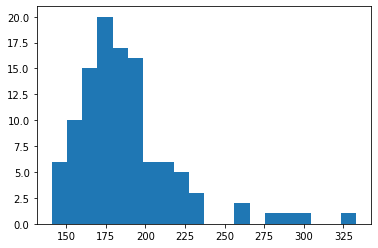

In [280]:
plt.hist(data["pegasus_summaries"].str.len(), bins=20)


(array([ 3.,  4.,  6.,  6.,  5.,  8.,  5.,  6.,  5.,  2.,  4.,  8.,  9.,
         8.,  8., 11.,  4.,  3.,  2.,  3.]),
 array([136.  , 151.25, 166.5 , 181.75, 197.  , 212.25, 227.5 , 242.75,
        258.  , 273.25, 288.5 , 303.75, 319.  , 334.25, 349.5 , 364.75,
        380.  , 395.25, 410.5 , 425.75, 441.  ]),
 <BarContainer object of 20 artists>)

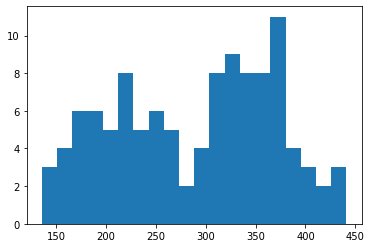

In [281]:
plt.hist(data["t5_summaries"].str.len(), bins=20)


In [ ]:
data[""]

In [295]:
pegasus_biased = data[data["pegasus_xlnet_predicted_labels"]==1]

In [306]:
def distance(x, y):
    return abs(x-y)

(array([ 1.,  0.,  0.,  0.,  0., 13.,  0.,  3.,  0.,  3.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

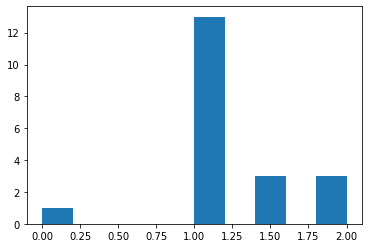

In [313]:
pegasus_biased = data[data["pegasus_xlnet_predicted_labels"]==1]
pegasus_bias_distance = pegasus_biased.apply(lambda row: distance(row["democrat.bias"], row["republican.bias"]), axis = 1) 
plt.hist(pegasus_bias_distance)

<AxesSubplot:>

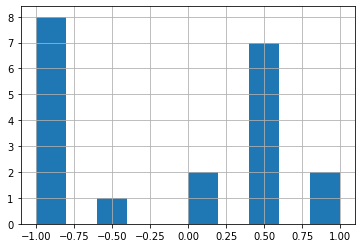

In [315]:
pegasus_biased["democrat.bias"].hist()

In [326]:
pegasus_biasedplot = pegasus_biased["democrat.bias"].value_counts()/len(real_biased)
pegasus_biasedplot

-1.0    0.166667
 0.5    0.145833
 0.0    0.041667
 1.0    0.041667
-0.5    0.020833
Name: democrat.bias, dtype: float64

 0.5    0.375000
-1.0    0.333333
-0.5    0.125000
 0.0    0.104167
 1.0    0.062500
Name: democrat.bias, dtype: float64

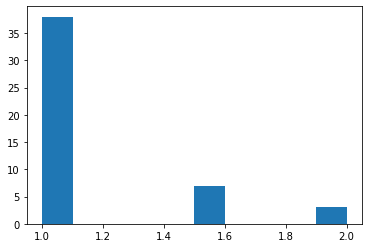

In [328]:
real_biased = data[data["test_labels"]==1]
real_bias_distance = real_biased.apply(lambda row: distance(row["democrat.bias"], row["republican.bias"]), axis = 1) 
plt.hist(real_bias_distance)
real_biasedplot = real_biased["democrat.bias"].value_counts()/len(real_biased)
real_biasedplot

<AxesSubplot:>

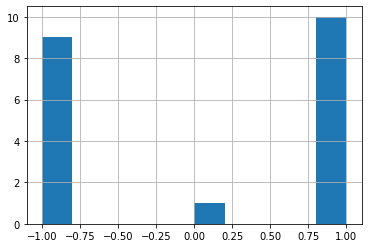

In [327]:
pegasus_biased.biascategories.hist()

In [333]:
pegasus_biased.text.iloc[2]

'washington — finally unburdened by worries about running for another election, president obama is acting different these days. second-term obama is noticeably quicker to speak his mind and get personal on subjects he once avoided. his schedule at times ignores concerns about “optics,” washington-speak for what voters might perceive. advertisement on friday, for example, the president delivered an unexpectedly personal, and at times off-the-cuff, speech in chicago about the root causes of urban violence. the famously reserved president spoke bluntly about the kenyan-born father whom he barely knew, and his wayward high school days in hawaii. “i wish i had had a father who was around and involved,” he said. advertisement in the past, obama typically wove the uplifting version of his personal narrative — raised by a single mother, loved by doting grandparents — into his campaign message. he rarely admitted to having “issues,” as he did in chicago. then, over the presidents day weekend, o

In [334]:
pegasus_biased.iloc[2]

index                                                                          9055
url                               http://www.latimes.com/news/nationworld/nation...
q3                                                                             News
perceived                                                                         1
primary.topic                                                             Elections
secondary.topic                                                                None
democrat.vote                                                              Positive
republican.vote                                                             Neutral
article                           washington — finally unburdened by worries abo...
length                                                                          600
democrat.bias                                                                   1.0
republican.bias                                                             

In [293]:
data.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,ALBERT,encodedlabel,TFIDF,t5_xlnet_predicted_labels,pegasus_xlnet_predicted_labels,t5_tfidf_predicted_labels,pegasus_tfidf_predicted_labels,test_labels,t5_summaries,pegasus_summaries
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,0,0,0,1,1,1,0,1,gop's ken cuccinelli has been downplaying his ...,The Republican Party in Virginia is trying to ...
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,1,0,1,0,0,0,0,president obama unveiled legislative proposals...,In the wake of last week's school shooting in ...
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,0,0,0,1,0,1,0,1,"david frum: obama's second term will be silly,...","The president of the United States of America,..."
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,1,0,0,1,1,1,1,1,republicans have made the mountain west a stro...,"In the mountains of western virginia, republic..."
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,1,0,0,1,1,0,1,1,president obama is noticeably quicker to speak...,With less than two weeks to go before American...


In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.bar()


(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
bertmodeldata = pd.read_table("bertmodeldata.csv", sep='\t', index_col=0)
robertamodeldata = pd.read_table("robertamodeldata.csv", sep='\t', index_col=0)
# frozenrobertamodeldata = pd.read_table("frozenrobertamodeldata.csv", sep='\t', index_col=0)
xlnetmodeldata = pd.read_table("xlnetmodeldata.csv", sep='\t', index_col=0)
# frozenxlnetmodeldata = pd.read_table("frozenxlnetmodeldata.csv", sep='\t', index_col=0)
albertmodeldata = pd.read_table("albertmodeldata.csv", sep='\t', index_col=0)


In [ ]:
bert_val_acc = bertmodeldata['ValAccuracy']
roberta_val_acc = robertamodeldata['ValAccuracy']
xlnet_val_acc = xlnetmodeldata['ValAccuracy']
albert_val_acc = albertmodeldata['ValAccuracy']

bert_val_loss = bertmodeldata['Val_loss']
roberta_val_loss = robertamodeldata['Val_loss']
# frozenroberta_val_loss = frozenrobertamodeldata['Val_loss']
xlnet_val_loss = xlnetmodeldata['Val_loss']
# frozenxlnet_val_loss = frozenxlnetmodeldata['Val_loss']
albert_val_loss = albertmodeldata['Val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bert_val_acc, label='BERT')
plt.plot(epochs_range, roberta_val_acc, label='RoBERTa')
# plt.plot(epochs_range, frozenroberta_val_acc, label='RoBERTa (6 layers trained)')
plt.plot(epochs_range, xlnet_val_acc, label='XLNet')
plt.plot(epochs_range, albert_val_loss, label='ALBERT')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bert_val_loss, label='BERT')
plt.plot(epochs_range, roberta_val_loss, label='RoBERTa')
# plt.plot(epochs_range, frozenroberta_val_loss, label='RoBERTa (6 layers trained)')
plt.plot(epochs_range, xlnet_val_loss, label='XLNet')
plt.plot(epochs_range, albert_val_loss, label='ALBERT')
plt.legend(loc='upper right')
plt.title('Validation Loss')
# plt.show()
plt.savefig('modeltrainingcomparison.jpg')

In [ ]:
# plot accuracy

In [ ]:
def findcommonlabel(predictionlist):
    labellist = []
    for i in range(len(predictionlist[1])):
        allin = True
        labeli = predictionlist[0][i]
        for ii in range(len(predictionlist)):
            if predictionlist[ii][i] !=labeli:
                allin = False
        if allin == True:
            labellist.append(i)
    return labellist

In [ ]:
commonpred = findcommonlabel(predictions)
len(commonpred)

In [ ]:
test_section.reset_index(inplace=True)
test_section.head()

In [ ]:
commonpreddata = test_section.iloc[commonpred]
commonpreddata.shape

In [ ]:
commonpreddata["label"].value_counts().plot.bar()

In [ ]:
plt.hist(commonpreddata.length)


In [ ]:
mixedpreddata = test_section.drop(commonpred, errors='ignore')
mixedpreddata.shape

In [ ]:
mixedpreddata["label"].value_counts().plot.bar()

In [ ]:
plt.hist(mixedpreddata.length)


In [ ]:
for i in range(len(names)):
    test_section[names[i]] = predictions[i]
test_section['encodedlabel'] = test_labels
test_section.head()

In [ ]:
def calculateproportions(df, colname):
    biases = df[df[colname] == 0]
    neutrals = df[df[colname] == 1]
    length = df.shape[0]
    return biases.shape[0]/length, neutrals.shape[0]/length

In [ ]:
realbiasproportions, realneutralproportions = calculateproportions(test_section, "encodedlabel")
bertbiasproportions, bertneutralproportions = calculateproportions(test_section, "BERT")
robertabiasproportions, robertaneutralproportions = calculateproportions(test_section, "RoBERTa")
xlnetbiasproportions, xlnetneutralproportions = calculateproportions(test_section, "XLNet")
albertbiasproportions, albertneutralproportions = calculateproportions(test_section, "ALBERT")

biasproplist = [realbiasproportions,
               bertbiasproportions,
               robertabiasproportions,
                xlnetbiasproportions,
                albertbiasproportions]
neutralproplist = [realneutralproportions,
               bertneutralproportions,
               robertaneutralproportions,
                xlnetneutralproportions,
                albertneutralproportions]
                
totalnames = ["Data", "BERT","RoBERTa", "XLNet", "ALBERT"]
plt.bar(range(0, len(biasproplist)), biasproplist, width = 0.25, tick_label = totalnames)
plt.ylim(ymin=0.3)
plt.title('Proportions of Biased Labels')



In [ ]:
plt.bar(range(0, len(neutralproplist)), neutralproplist, width = 0.25, tick_label = totalnames)
plt.ylim(ymin=0.5)
plt.title('Proportions of Neutral Labels')



In [ ]:
test_section[:10]

In [ ]:
realneutraldata = test_section[(test_section["encodedlabel"] ==1)
            & (test_section["BERT"]== 0)
             & (test_section["RoBERTa"]== 0)
             & (test_section["XLNet"]== 0)
             & (test_section["ALBERT"]== 0)]
realneutraldata

In [ ]:
test_section.iloc[9].url

In [ ]:
test_section.iloc[9].article

In [ ]:
xlnetbiasvsneutral = test_section[(test_section["encodedlabel"] ==1)
             & (test_section["XLNet"]== 0)]
xlnetbiasvsneutral

In [ ]:
realbiasdata = test_section[(test_section["encodedlabel"] ==0)
            & (test_section["BERT"]== 1)
             & (test_section["RoBERTa"]== 1)
             & (test_section["XLNet"]== 1)]
realbiasdata

In [ ]:
test_section[(test_section["encodedlabel"] ==0)
            & (test_section["XLNet"]== 1)]

In [352]:
breitbartdata = pd.read_table("biaseddata.csv", sep='\t', index_col=0)


In [353]:
breitbartdata[breitbartdata['article']=='on sunday evening, cbs news’ 60 minutes featured an investigative report on the benghazi attacks by lara logan. logan’s reporting confirmed that the obama administration had been warned, months in advance, about inadequate security at the u.s. facility in benghazi, and that it knew the story about a youtube video was untrue. it was a reversal for cbs news, which played a key role in the benghazi cover-up in 2012.  a year ago, cbs news released a previously unaired clip of an interview for 60 minutes with president barack obama on sep. 12, the day after the benghazi attack, in which the president suggests clearly that the attack on the u.s. consulate was premeditated. the interview contradicted obama’s subsequent claims that the attack had been a response to an anti-islam youtube video, repeated to the public for several days.  cbs news had withheld that portion of the sep. 12 interview until oct. 19, choosing instead to release a portion in which obama criticized rival mitt romney’s condemnation of the administration’s response to events–a repeated theme as the media helped obama deflect responsibility. romney had attacked the white house’s apology for the video during the attack on the cairo embassy, not knowing of the deaths in libya.  after the election, kroft continued to insist that there was “no information that anything’s been covered up” by the media or the obama administration about the benghazi attacks. that statement was wrong based on what was known at the time, and looks even worse today, after whistleblowers testified to congress earlier this year they were pressured by clinton’s chief of staff not to cooperate with congressional investigators.  logan’s investigation featured an interview with one of those whistleblowers, greg hicks, who had been the deputy to slain u.s. ambassador chris stevens. logan also interviewed “morgan jones” (pseudonym), a former british soldier who had been advising the u.s. on security in benghazi and had warned the state department that libyan guards being trained to guard the compound were not up to the job.  morgan’s warnings came to fruition on sep. 11, 2012, when he saw the guards disperse after being told by the attackers: “we’re here to kill americans, not libyans.” morgan did what little he could to stop the attack. a second attack at the cia annex was partly fought off by a small group that saved five american lives and has since, logan reported, earned “the distinguished service cross and the navy cross” for its bravery.  yet the obama administration did not send any assistance throughout the night, and is thought to have issued a stand-down order to prevent any intervention. what logan’s report makes clear is that there is no way that president obama or his secretary of state could plausibly claim that a youtube video had inspired a spontaneous act of violence on that scale against the u.s. consulate, the cia annex and their personnel.  that story was a lie when it was told–and it was a lie aided and abetted by the mainstream media, including cbs news and 60 minutes, which could have exploded the administration’s youtube video alibi even as obama and clinton were telling it to the families of the victims, to the voting public, and to the world. the sunday night report is commendable, but as an attempt to atone for malpractice, it is far too little, too late.']

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories
2625,http://www.breitbart.com/Big-Journalism/2013/1...,News,0,Democrat Scandals,International News,Negative,SomewhatPositive,"on sunday evening, cbs news’ 60 minutes featur...",561,-1.0,0.5,Very Conservative,1,-1
3538,http://www.breitbart.com/Big-Journalism/2013/1...,News,1,International News,National Security,Neutral,Neutral,"on sunday evening, cbs news’ 60 minutes featur...",561,0.0,0.0,Neutral,0,0


In [7]:
data.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,ALBERT,encodedlabel,TFIDF,t5_xlnet_predicted_labels,pegasus_xlnet_predicted_labels,t5_tfidf_predicted_labels,pegasus_tfidf_predicted_labels,test_labels,t5_summaries,pegasus_summaries
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,0,0,0,1,1,1,0,1,gop's ken cuccinelli has been downplaying his ...,The Republican Party in Virginia is trying to ...
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,1,0,1,0,0,0,0,president obama unveiled legislative proposals...,In the wake of last week's school shooting in ...
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,0,0,0,1,0,1,0,1,"david frum: obama's second term will be silly,...","The president of the United States of America,..."
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,1,0,0,1,1,1,1,1,republicans have made the mountain west a stro...,"In the mountains of western virginia, republic..."
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,1,0,0,1,1,0,1,1,president obama is noticeably quicker to speak...,With less than two weeks to go before American...


In [ ]:
# Metrics in comparison to XLNet predicted article labels

In [8]:
t5_xlnet_predicted_labels = data['t5_xlnet_predicted_labels']
pegasus_xlnet_predicted_labels = data['pegasus_xlnet_predicted_labels']
t5_tfidf_predicted_labels = data['t5_tfidf_predicted_labels']
pegasus_tfidf_predicted_labels = data['pegasus_tfidf_predicted_labels']
test_labels = data['XLNet'] 

In [9]:
predlist = [t5_xlnet_predicted_labels,
           pegasus_xlnet_predicted_labels,
           t5_tfidf_predicted_labels,
           pegasus_tfidf_predicted_labels
           ]
namelist = ["XLNet (T5)",
           "XLNet (Pegasus)",
           "TF-IDF (T5)",
           "TF-IDF (Pegasus)"]

In [12]:
modelaccuracylist = []
modelnamelist = []
modelprecisionlist = []
modelrecalllist = []
modelf1list = []
mlist = []
print("Metrics for Biased as baseline class (0):")
print()
for i in range(len(predlist)):
    test_classes = predlist[i]
    modelname = namelist[i]
    modelnamelist.append(modelname)
    print(modelname +" Metrics:")
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(test_labels, test_classes)
    print('Accuracy: %f' % accuracy)
    modelaccuracylist.append(accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(test_labels, test_classes)
    print('Precision: %f' % precision)
    modelprecisionlist.append(precision)
    # recall: tp / (tp + fn)
    recall = recall_score(test_labels, test_classes)
    print('Recall: %f' % recall)
    modelrecalllist.append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_labels, test_classes)
    modelf1list.append(f1)
    print('F1 score: %f' % f1)
    mlist.append([accuracy, precision, recall, f1])
#     print(classification_report(test_labels,test_classes))
    print("")
 

Metrics for Biased as baseline class (0):

XLNet (T5) Metrics:
Accuracy: 0.236364
Precision: 0.242424
Recall: 0.119403
F1 score: 0.160000

XLNet (Pegasus) Metrics:
Accuracy: 0.281818
Precision: 0.200000
Recall: 0.059701
F1 score: 0.091954

TF-IDF (T5) Metrics:
Accuracy: 0.245455
Precision: 0.055556
Recall: 0.014925
F1 score: 0.023529

TF-IDF (Pegasus) Metrics:
Accuracy: 0.318182
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000



In [13]:
df = pd.DataFrame(columns = modelnamelist)
df.loc['Accuracy'] = modelaccuracylist
df.loc['Precision'] = modelprecisionlist
df.loc['Recall'] = modelrecalllist
df.loc['F1'] = modelf1list
df.head()

,XLNet (T5),XLNet (Pegasus),TF-IDF (T5),TF-IDF (Pegasus)
Accuracy,0.236364,0.281818,0.245455,0.318182
Precision,0.242424,0.200000,0.055556,0.000000
Recall,0.119403,0.059701,0.014925,0.000000
F1,0.160000,0.091954,0.023529,0.000000


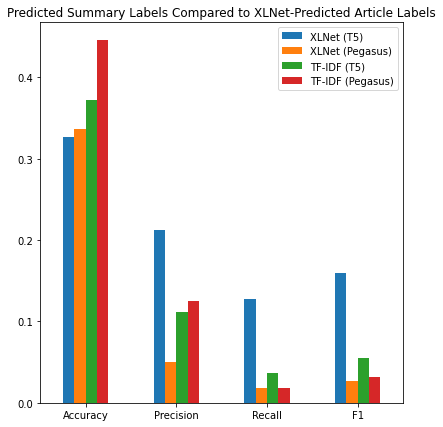

In [24]:
ax = df.plot.bar(rot=0)
ax.set_ylim()
ax.figure.set_size_inches(6.5, 7)
plt.title('Predicted Summary Labels Compared to XLNet-Predicted Article Labels')
# plt.show()
plt.savefig('predlabelmodelxlnetmetriccomparison.jpg')

In [ ]:
# Metrics in comparison to TF-IDF predicted article labels

In [16]:
t5_xlnet_predicted_labels = data['t5_xlnet_predicted_labels']
pegasus_xlnet_predicted_labels = data['pegasus_xlnet_predicted_labels']
t5_tfidf_predicted_labels = data['t5_tfidf_predicted_labels']
pegasus_tfidf_predicted_labels = data['pegasus_tfidf_predicted_labels']
test_labels = data['TFIDF'] 

In [17]:
predlist = [t5_xlnet_predicted_labels,
           pegasus_xlnet_predicted_labels,
           t5_tfidf_predicted_labels,
           pegasus_tfidf_predicted_labels
           ]
namelist = ["XLNet (T5)",
           "XLNet (Pegasus)",
           "TF-IDF (T5)",
           "TF-IDF (Pegasus)"]

In [18]:
modelaccuracylist = []
modelnamelist = []
modelprecisionlist = []
modelrecalllist = []
modelf1list = []
mlist = []
print("Metrics for Biased as baseline class (0):")
print()
for i in range(len(predlist)):
    test_classes = predlist[i]
    modelname = namelist[i]
    modelnamelist.append(modelname)
    print(modelname +" Metrics:")
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(test_labels, test_classes)
    print('Accuracy: %f' % accuracy)
    modelaccuracylist.append(accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(test_labels, test_classes)
    print('Precision: %f' % precision)
    modelprecisionlist.append(precision)
    # recall: tp / (tp + fn)
    recall = recall_score(test_labels, test_classes)
    print('Recall: %f' % recall)
    modelrecalllist.append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_labels, test_classes)
    modelf1list.append(f1)
    print('F1 score: %f' % f1)
    mlist.append([accuracy, precision, recall, f1])
#     print(classification_report(test_labels,test_classes))
    print("")
 

Metrics for Biased as baseline class (0):

XLNet (T5) Metrics:
Accuracy: 0.327273
Precision: 0.212121
Recall: 0.127273
F1 score: 0.159091

XLNet (Pegasus) Metrics:
Accuracy: 0.336364
Precision: 0.050000
Recall: 0.018182
F1 score: 0.026667

TF-IDF (T5) Metrics:
Accuracy: 0.372727
Precision: 0.111111
Recall: 0.036364
F1 score: 0.054795

TF-IDF (Pegasus) Metrics:
Accuracy: 0.445455
Precision: 0.125000
Recall: 0.018182
F1 score: 0.031746



In [19]:
df = pd.DataFrame(columns = modelnamelist)
df.loc['Accuracy'] = modelaccuracylist
df.loc['Precision'] = modelprecisionlist
df.loc['Recall'] = modelrecalllist
df.loc['F1'] = modelf1list
df.head()

,XLNet (T5),XLNet (Pegasus),TF-IDF (T5),TF-IDF (Pegasus)
Accuracy,0.327273,0.336364,0.372727,0.445455
Precision,0.212121,0.050000,0.111111,0.125000
Recall,0.127273,0.018182,0.036364,0.018182
F1,0.159091,0.026667,0.054795,0.031746


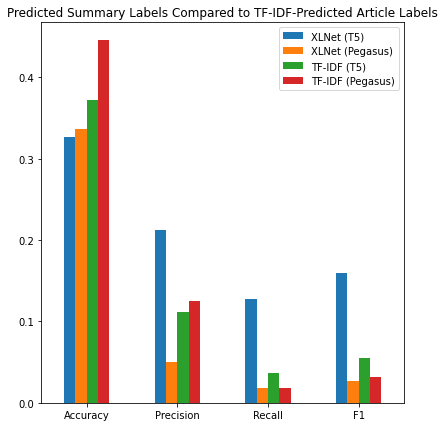

In [25]:
ax = df.plot.bar(rot=0)
ax.set_ylim()
ax.figure.set_size_inches(6.5, 7)
plt.title('Predicted Summary Labels Compared to TF-IDF-Predicted Article Labels')
# plt.show()
plt.savefig('predlabelmodelTFIDFmetriccomparison.jpg')